In [ ]:
#importing some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 

In [ ]:
#downloading olid dataset
!wget https://raw.githubusercontent.com/idontflow/OLID/master/olid-training-v1.0.tsv 
!wget https://raw.githubusercontent.com/idontflow/OLID/master/own/cleaned_train_data_v1.csv

--2021-01-12 10:34:49--  https://raw.githubusercontent.com/idontflow/OLID/master/olid-training-v1.0.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1961915 (1.9M) [text/plain]
Saving to: ‘olid-training-v1.0.tsv’

olid-training-v1.0. 100%[===================>]   1.87M  --.-KB/s    in 0.1s    

2021-01-12 10:34:51 (17.9 MB/s) - ‘olid-training-v1.0.tsv’ saved [1961915/1961915]

--2021-01-12 10:34:51--  https://raw.githubusercontent.com/idontflow/OLID/master/own/cleaned_train_data_v1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28886

In [ ]:
#reading the dataset
olid=pd.read_csv('olid-training-v1.0.tsv',sep='\t')

In [ ]:
olid.head(5)

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [ ]:
olid_clean=pd.read_csv('cleaned_train_data_v1.csv') 

In [ ]:
olid_clean.head(5)

,del,id,tweet,subtask_a,subtask_b,subtask_c,cleaned_tweet
0,0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,ask native americans take
1,1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,go home drunk maga trump 2020
2,2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,amazon investigating chinese employees selling...
3,3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,someone vetaken piece shit volcano
4,4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,obama wanted liberals illegals move red states


In [ ]:
olid['tweet']=olid_clean['cleaned_tweet'].apply(str) 

In [ ]:
#taking only required columns
olid.rename(columns = {'tweet':'text'}, inplace = True) 
olid.rename(columns = {'subtask_a':'label'}, inplace = True)
mapping = {'OFF': 1, 'NOT': 0}
olid=olid.replace({'label': mapping}) 
train=olid[['id','text','label']]
print(train.head()) 

      id                                               text  label
0  86426                          ask native americans take      1
1  90194                      go home drunk maga trump 2020      1
2  16820  amazon investigating chinese employees selling...      0
3  62688                 someone vetaken piece shit volcano      1
4  43605     obama wanted liberals illegals move red states      0


In [ ]:
text_len=[]
for val in olid['text']: 
    val = str(val) 
    tokens = val.split() 
    text_len.append(len(tokens))

In [ ]:
max(text_len)

42

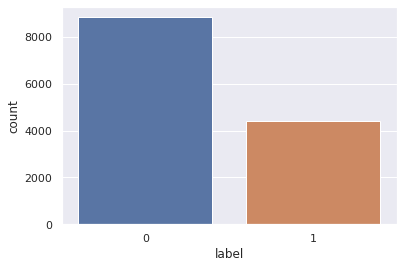

In [ ]:
#visualizing data distribution
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=train)

In [ ]:
train['label'].value_counts(normalize=True) * 100

0    66.767372
1    33.232628
Name: label, dtype: float64

In [ ]:
#splitting dataset for training and validation
from sklearn.model_selection import train_test_split
X = train.text.values
y = train.label.values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42) 

In [ ]:
#gpu setup
import torch
import torch.nn as nn

device = torch.device("cuda")

In [ ]:
#installing transformers
!pip install transformers
from transformers import BertModel

     |████████████████████████████████| 1.5MB 4.2MB/s 
     |████████████████████████████████| 2.9MB 36.0MB/s 
     |████████████████████████████████| 890kB 41.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=153466a53201832761a0c8ccc21ab006a44bf4f44d44afe8010357663ff5be1f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#importing bert tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [ ]:
#adding special tokens
def special_tokens(texts):
  texts = ["[CLS] " + text + " [SEP]" for text in texts]
  print(texts[0])
  return texts

In [ ]:
#tokenizing sentences
def text_tokenize(texts):
  texts = [tokenizer.tokenize(text) for text in texts]
  print(texts[0])
  return texts

In [ ]:
#adding input_ids
from tqdm import  tqdm_notebook
def adding_ids(texts):
  input_ids=[]
  for i in tqdm_notebook(range(len(texts))):
    input_ids.append(tokenizer.convert_tokens_to_ids(texts[i]))
  return input_ids

In [ ]:
#adding attention_masks
def adding_masks(ids):
  attention_masks=[]
  for seq in ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  return attention_masks

In [ ]:
texts=special_tokens(X_train)
texts=text_tokenize(texts)
input_ids_train=adding_ids(texts)
from keras.preprocessing.sequence import pad_sequences
input_ids_train = pad_sequences(input_ids_train, maxlen=400, dtype="long", truncating="post", padding="post")
input_ids_train = torch.tensor(input_ids_train)
attention_mask_train=adding_masks(input_ids_train)
attention_mask_train = torch.tensor(attention_mask_train)

[CLS] washingtonpost broke story therapist notes miss ford stated four men assaulted two votedemsout end dirtytricks stop wrong dc kavanaugh maga foxnews liar cnn msnbc senflake wrong use metoo politics christineblaseyford [SEP]
['[CLS]', 'washington', '##post', 'broke', 'story', 'the', '##rap', '##ist', 'notes', 'miss', 'ford', 'stated', 'four', 'men', 'assault', '##ed', 'two', 'voted', '##ems', '##out', 'end', 'dirty', '##tric', '##ks', 'stop', 'wrong', 'dc', 'ka', '##vana', '##ugh', 'maga', 'fox', '##news', 'liar', 'cnn', 'msn', '##bc', 'sen', '##fla', '##ke', 'wrong', 'use', 'met', '##oo', 'politics', 'christine', '##bla', '##sey', '##ford', '[SEP]']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
attention_mask_train

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [ ]:
input_ids_train

tensor([[  101, 11013, 49799,  ...,     0,     0,     0],
        [  101, 20782, 11975,  ...,     0,     0,     0],
        [  101, 12976, 10502,  ...,     0,     0,     0],
        ...,
        [  101, 12873,   102,  ...,     0,     0,     0],
        [  101, 12603, 12838,  ...,     0,     0,     0],
        [  101, 26855, 10301,  ...,     0,     0,     0]])

In [ ]:
texts=special_tokens(X_val)
texts=text_tokenize(texts)
input_ids_val=adding_ids(texts)
input_ids_val = pad_sequences(input_ids_val, maxlen=400, dtype="long", truncating="post", padding="post")
input_ids_val = torch.tensor(input_ids_val)
attention_mask_val=adding_masks(input_ids_val)
attention_mask_val = torch.tensor(attention_mask_val)

[CLS] john kerry running mouth cared say think single damn thing kerry accomplished besides run mouth trump accomplishments exceed anything kerry could ever dream even becoming president [SEP]
['[CLS]', 'john', 'kerry', 'running', 'mouth', 'care', '##d', 'say', 'think', 'single', 'dam', '##n', 'thing', 'kerry', 'accomplished', 'besides', 'run', 'mouth', 'trump', 'acc', '##om', '##pli', '##shme', '##nts', 'ex', '##cee', '##d', 'anything', 'kerry', 'could', 'ever', 'dream', 'even', 'becoming', 'president', '[SEP]']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
train_label = torch.tensor(y_train)
val_label = torch.tensor(y_val)

In [ ]:
from torch.utils.data import TensorDataset
train_data = TensorDataset(input_ids_train, attention_mask_train, train_label)
val_data = TensorDataset(input_ids_val, attention_mask_val, val_label)

In [ ]:
print(input_ids_train.shape)
print(attention_mask_train.shape)
print(train_label.shape)

torch.Size([11916, 400])
torch.Size([11916, 400])
torch.Size([11916])


In [ ]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_data, shuffle=False, batch_size=8)
for i, batch in enumerate(train_loader):
        print(i, batch)

Streaming output truncated to the last 5000 lines.
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([0, 0, 0, 1, 1, 0, 0, 0])]
1105 [tensor([[  101, 13502, 29104,  ...,     0,     0,     0],
        [  101, 20587, 89241,  ...,     0,     0,     0],
        [  101, 11157, 13502,  ...,     0,     0,     0],
        ...,
        [  101, 31617, 33413,  ...,     0,     0,     0],
        [  101, 37783, 13502,  ...,     0,     0,     0],
        [  101, 31617, 16464,  ...,     0,     0,     0]]), tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([0, 0, 0, 1, 0, 0, 0, 1])]
1106 [tensor([[  101, 16017, 26806,  ...,     0,     0,     0],
        [  101, 10445, 60982,  ...,     0,     0,     0],
        [  101, 88633, 10287,  ...,     0,     0,     0],
        ...,
        [  101, 11146,

In [ ]:
val_loader=DataLoader(val_data, shuffle=False, batch_size=8)
for i, batch in enumerate(val_loader):
        print(i, batch)

0 [tensor([[  101, 10469, 45307,  ...,     0,     0,     0],
        [  101, 15260, 12212,  ...,     0,     0,     0],
        [  101, 12111, 10504,  ...,     0,     0,     0],
        ...,
        [  101, 13502, 13240,  ...,     0,     0,     0],
        [  101, 10695, 18171,  ...,     0,     0,     0],
        [  101, 16464, 10277,  ...,     0,     0,     0]]), tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]), tensor([0, 0, 0, 0, 0, 0, 1, 1])]
1 [tensor([[  101, 86229, 12574,  ...,     0,     0,     0],
        [  101, 25044, 20550,  ...,     0,     0,     0],
        [  101, 16566, 10373,  ...,     0,     0,     0],
        ...,
        [  101, 59386, 11128,  ...,     0,     0,     0],
        [  101, 39898, 15878,  ...,     0,     0,     0],
        [  101, 67715, 16563,  ...,    

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()
        input, hidden, out = 768, 50, 2
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')
        self.classifier = nn.Sequential(
            nn.Linear(input, hidden),
            nn.GELU(),
            nn.Linear(hidden, out)
        )
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [ ]:
bert_classifier = BertClassifier(freeze_bert=False)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,   
                      eps=1e-8   
                      )

In [ ]:
total_steps = len(train_loader)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

In [ ]:
bert_classifier.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
import time
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            if (step % 80 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()
        avg_train_loss = total_loss / len(train_dataloader)
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

def evaluate(model, val_dataloader):
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

In [ ]:
train(bert_classifier, train_loader, val_loader, epochs=2, evaluation=True) 

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   0.543936   |  0.505031  |   77.56   |  1863.05 
----------------------------------------------------------------------


 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   0.449510   |  0.505031  |   77.56   |  1863.55 
----------------------------------------------------------------------




In [ ]:
def bert_predict(model, test_dataloader):
    model.eval()
    all_logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0)
    m = nn.Softmax(dim=0)
    probs=m(all_logits).cpu().numpy()
    return probs

In [ ]:
from sklearn.metrics import confusion_matrix 

In [ ]:
probs = bert_predict(bert_classifier, val_loader)
ypred = []
for i in probs:
  ypred.append(i.argmax())

In [ ]:
actual = y_val 
predicted = ypred
results = confusion_matrix(actual, predicted)

In [ ]:
from sklearn.metrics import classification_report
print ('Confusion Matrix :')
print(results) 
print ('Report : ')
print (classification_report(actual, predicted) )

Confusion Matrix :
[[661 191]
 [127 345]]
Report : 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       852
           1       0.64      0.73      0.68       472

    accuracy                           0.76      1324
   macro avg       0.74      0.75      0.75      1324
weighted avg       0.77      0.76      0.76      1324



In [ ]:
#importing the test dataset
df2 = pd.read_csv('https://query.data.world/s/5zp7kqkhp6aycvezneyvw4s5vncwyp')
df2['WeekID'] =pd.to_datetime(df2.WeekID)
df2['Year'] = pd.DatetimeIndex(df2['WeekID']).year
df2.rename(columns = {'Year':'id'}, inplace = True) 
df2.rename(columns = {'Lyrics':'text'}, inplace = True)
test=df2[['id','text']]
print(test.head())

     id                                               text
0  1958  For your love, oh, I would do anything\nI woul...
1  1958  Do you want to dance and hold my hand?\nTell m...
2  1958  Well...\n\nYou're gonna miss me\nEarly in the ...
3  1958  VERSE 1\nThe night was black, rain falling dow...
4  1958  You need hands\nTo hold someone you care for\n...


In [ ]:
song_len=[]
for val in test.text: 
    val = str(val) 
    tokens = val.split() 
    song_len.append(len(tokens))

In [ ]:
max(song_len)

152084

In [ ]:
song_len = [x for x in song_len if x <1000]

(array([2.4708e+04, 4.9500e+02, 2.8200e+02, 2.1500e+02, 1.7800e+02,
        2.6000e+01, 2.5000e+01, 1.0000e+01, 2.4000e+01, 5.0000e+00,
        0.0000e+00, 1.8000e+01, 3.3000e+01, 1.0000e+00, 1.5000e+01,
        8.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 9.4000e+01]),
 array([1.0000000e+00, 7.6051500e+03, 1.5209300e+04, 2.2813450e+04,
        3.0417600e+04, 3.8021750e+04, 4.5625900e+04, 5.3230050e+04,
        6.0834200e+04, 6.8438350e+04, 7.6042500e+04, 8.3646650e+04,
        9.1250800e+04, 9.8854950e+04, 1.0645910e+05, 1.1406325e+05,
        1.2166740e+05, 1.2927155e+05, 1.3687570e+05, 1.4447985e+05,
        1.5208400e+05]),
 <a list of 20 Patch objects>)

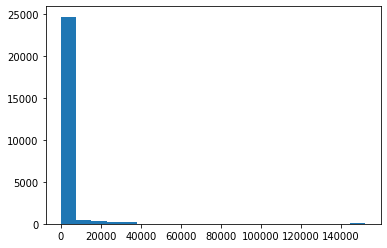

In [ ]:
plt.hist(song_len,bins=20)

In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 4.1MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=3970ef40292362f1f2b70f2516a466a8a1453092808945c4cdba1283353d7a92
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
from langdetect import detect 
def text_language(text):
  text=text.split(" ")
  text=text[20:40]
  try:
    val = detect(" ".join(text))
  except:
    val = "error"
  return val

In [ ]:
test['language']=test['text'].apply(text_language)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
yrs=[2014,2015,2016,2017,2018,2019]
all_preds=[]
preds_all=[]
df=pd.DataFrame()
for yr in yrs:
  test1=test.loc[test['id'] == yr]
  test1=test1.loc[test1['language'] == 'en']
  df=df.append(test1)
  texts=special_tokens(test1.text)
  texts=text_tokenize(texts)
  input_ids_test=adding_ids(texts)
  input_ids_test = pad_sequences(input_ids_test, maxlen=400, dtype="long", truncating="post", padding="post")
  input_ids_test = torch.tensor(input_ids_test)
  attention_mask_test=adding_masks(input_ids_test)
  attention_mask_test = torch.tensor(attention_mask_test)
  test_dataset = TensorDataset(input_ids_test, attention_mask_test)
  test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)
  probs = bert_predict(bert_classifier, test_dataloader)
  ypred = []
  for i in probs:
    ypred.append(i.argmax())
  ypred = pd.Index(ypred)
  print(yr)
  preds_all.append(ypred.values)
  all_preds.append([yr, ypred.value_counts()])

[CLS] [Intro: Sample]
"Flight controllers here looking very carefully at the situation
Obviously a major malfunction"

[Verse 1]
Your love is bright as ever
Even in the shadows
Baby, kiss me
Before they turn the lights out
Your heart is glowing
And Iâm crashing into you
Baby, kiss me
Before they turn the lights out
Before they turn the lights out
Baby, love me lights out

[Chorus]
In the darkest night hour (In the darkest night hour)
Search through the crowd (Search through the crowd)
Your face is all that I see
I've given you everything
Baby, love me lights out
Baby, love me lights out
(XO)
You can turn my lights out

[Verse 2]
We donât have forever
Baby, daylightâs wasting
You better kiss me
Before our time has run out
Nobody sees what we see
Theyâre just hopelessly gazing
Baby, take me
Before they turn the lights out
Before our time has run out
Baby, love me lights out

[Chorus]
In the darkest night hour (In the darkest night hour)
I'll search through the crowd (I'll search 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



2014
[CLS] [Intro]
I just wanna

[Verse 1]
It's in the air
The way you smile when you reciprocate my stare
Just one breath and everyone knows that you're there
With every hit I take, you move that waist and I wanna die
A girl like you, adore
The way you drop that thing could start another war
And my hands are gettin' eager to explore
Cherry lips are singin' "Purple Rain" and I feel alive

[Pre-Chorus]
I take the wheel and grab the clutch
Your body should be mine to touch
I fit the rhythm your body's givin'
And once I get in there

[Chorus]
She got the smoothest ride
Like velvet all inside
Her sex just changed my life
She rides like a dream
And damn that velvet looks good on me

[Verse 2]
I feel the heat
Every drop of you is rainin' down on me
You're perfection's foggin' up my window seat
I got your body switchin' all positions through the night

[Pre-Chorus] + [Chorus]

[Outro] x4
She rides like a dream
Velvet looks good on me [SEP]
['[CLS]', '[', 'intro', ']', 'i', 'just', 'wanna', '

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



2015
[CLS] Supreme Court
BROWN v. ENTERTAINMENT MERCHANTS ASSN. ( No. 08-1448 )
556 F. 3d 950, affirmed.
Syllabus

Opinion: Scalia
Concurrence: Alito
Dissent: Thomas
Dissent: Breyer
SyllabusSUPREME COURT OF THE UNITED STATES
BROWN, GOVERNOR OF CALIFORNIA, et al. v .
ENTERTAINMENT MERCHANTS ASSOCIATION et al.

Certiorari to the united states court of appeals for the ninth circuit

No. 08â1448.âArgued November 2, 2010âDecided June 27, 2011
Respondents, representing the video-game and software industries, filed a preenforcement challenge to a California law that restricts the sale or rental of violent video games to minors. The Federal District Court concluded that the Act violated the First Amendment and permanently enjoined its enforcement. The Ninth Circuit affirmed.

Held:  The Act does not comport with the First Amendment . Pp. 2â18.

(a) Video games qualify for First Amendment protection. Like protected books, plays, and movies, they communicate ideas through familiar liter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



2016
[CLS] [Intro]
Yeah, Yeah, Yeah
I pull up roll the window down and
(pop pop pop pop pop)
I pull up roll the window down and
(pop pop pop pop pop)
I pull up roll the window down and
(pew pew pew)

[Hook]
I just bought a pistol it got 30 rounds in it
Pull up at yo momma house and put some rounds in it
Wet a nigga block and watch them niggas drown in it
Hunnid round drum gun a nigga down with it
I'm on that Slaughter Gang shit, Murder Gang shit
Slaughter Gang shit, Murder Gang shit
I'm on that Slaughter Gang shit, Murder Gang shit
Slaughter Gang shit, Murder Gang shit

[Verse 1]
I'm on that Slaughter Gang shit
Take a nigga bitch
Nigga yous a bitch cuz I ran off with ya shit
I'm a real right Blood and these niggas counterfeit
You don't pull up on the Ave pussy boy you get dipped
I bought a brand new drop and then I poured me up some drop
Y'all say real street nigga ya'll ain't on no block
Bitch, keep your legs closed 'cause all I want is top
I pull up and pew pew pew y'all gone call t

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



2017
[CLS] [Intro]
Murda on the beat, that's not nice, man

[Chorus: Quavo]
Real nigga, I
Get high, touch the sky
Right hand in the air
Left hand in the pot
Real nigga, I
We see eye to eye
Real nigga, I
We see eye to eye
Yeah yeah (yeah)

[Post-Chorus: Travis Scott]
I see green in your eyes, it don't lie (it's lit!)
Blue dollar bills in them hills to the sky (cash!)
We put the floor on dash
Know all my hoes they go and cash
Over that bag, they mad
I know the problem, yeah yeah

[Verse 1: Travis Scott]
Eye to eye (yeah!)
Trips to Dubai (yeah yeah)
I could see that they jealous, don't know why (yah)
Is it 'cause we lit at 4 AM at the spot?
Put that on your tongue, wait for the swag to unlock (yeah!)
If you searchin', come look for us (alright!), over the border (it's lit!)
We import 'em (yeah!), just don't record us (straight up!)
Poppin' at the crib, the livin' room look like The Forum
Roll the dice at night, I take the chance in the mornin'

[Interlude: Quavo]
Know what I mean?
We ain

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



2018
[CLS] [Intro]
Y'all know what's goin' on
21 Gang 'til I'm gone
4L Gang 'til I'm gone
If Young Metro don't trust you, I'm gon'â

[Verse 1]
Roll the window down, stick the Glock out (Stick the Glock out)
This chopper got a AMP, I'ma rock out (I'ma rock out)
When it's time for smoke, they gon' cop out (They gon' cop out)
This AK47 made in Moscow (Made in Moscow)
All these dead bodies got me seein' strange things (Straight up)
Both sides of the gun, I done dealt and felt the pain (On God)
Drive-by? Nah, we the walk-up gang (21)
I come from the 6 where they chalk up lames (On God)
Slide in and out (Out)
Spend the night? I doubt (Doubt)
Gold grill mouth (Mouth)
I come from the South (South)
We was stealin' cars
You was inside the house (Pussy)
I know he gon' be a rat one day
Right now we call him a mouse (21)

[Chorus]
I got lots of stripes, all my niggas shyst
You can roll the dice, you might lose your life
Keep my Desert Eagle on me, he not nothin' nice
I just need one Glock, Nas n

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



2019


In [ ]:
preds_all=pd.Series(preds_all)

In [ ]:
preds_all = preds_all.apply(pd.Series).stack().reset_index(drop = True) 

In [ ]:
df=pd.DataFrame(df)

In [ ]:
df=df.assign(Prediction=preds_all.values)

In [ ]:
df.head()

,id,text,language,Prediction
23722,2014,"[Intro: Sample]\n""Flight controllers here look...",en,0.0
23723,2014,[Verse 1]\nI see you and me riding like Bonnie...,en,1.0
23724,2014,[Verse 1: BeyoncÃ©]\nI've been watching for th...,en,0.0
23725,2014,"Share my life, take me for what I am\n'Cause I...",en,0.0
23726,2014,"[Chorus]\nI got my shades on, top back\nRollin...",en,1.0


In [ ]:
Offensive=df.loc[df['Prediction'] == 1]
notOffensive=df.loc[df['Prediction'] == 0]

In [ ]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
from nltk.corpus import stopwords 

words = '' 
stopwords = set(stopwords.words('english'))

for val in Offensive.text: 
    val = str(val) 
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


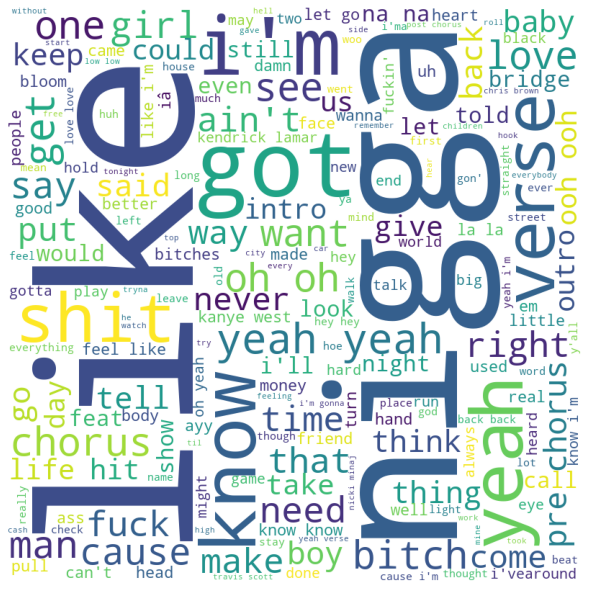

In [ ]:
plt.figure(figsize = (8,8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [ ]:
temp = []

for i in range(len(all_preds)):
  temp.append([all_preds[i][0], all_preds[i][1][0], all_preds[i][1][1]])

temp = pd.DataFrame(temp)
temp.columns = ['year', 'sent0', 'sent1']
temp

,year,sent0,sent1
0,2014,132,197
1,2015,145,228
2,2016,127,267
3,2017,145,266
4,2018,165,378
5,2019,73,157


In [ ]:
for i in range(6):
  sm=temp['sent0']+temp['sent1']
  temp['sent0']=(temp['sent0']/sm)*100
  temp['sent1']=(temp['sent1']/sm)*100

In [ ]:
import seaborn as sns

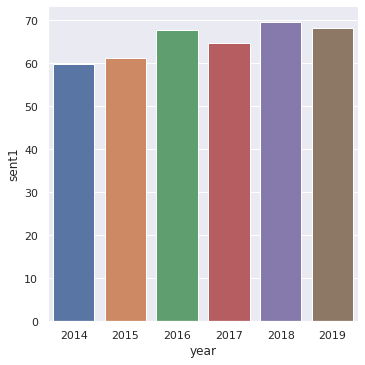

In [ ]:
sns.catplot(x="year",y="sent1",data=temp,kind='bar')

In [ ]:
!wget https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv

--2021-01-12 11:45:44--  https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2430416 (2.3M) [text/plain]
Saving to: ‘ToLD-BR.csv’

ToLD-BR.csv         100%[===================>]   2.32M  --.-KB/s    in 0.1s    

2021-01-12 11:45:46 (19.3 MB/s) - ‘ToLD-BR.csv’ saved [2430416/2430416]



In [ ]:
import pandas as pd
told_br=pd.read_csv('ToLD-BR.csv') 

In [ ]:
told_br['None']=told_br.apply(lambda row: row.homophobia + row.obscene+ row.insult+ row.racism+ row.misogyny+ row.xenophobia, axis=1)

In [ ]:
told_br.loc[told_br['None'] > 0, 'None'] = 1

In [ ]:
told_br.rename(columns = {'None':'label'}, inplace = True)
told_br=told_br[['text','label']]
print(told_br.head()) 

                                                text  label
0  Meu nivel de amizade com isis é ela ter meu in...    1.0
1  rt @user @user o cara adultera dados, que fora...    1.0
2  @user @user @user o cara só é simplesmente o m...    1.0
3  eu to chorando vei vsf e eu nem staneio izone ...    1.0
4  Eleitor do Bolsonaro é tão ignorante q não per...    1.0


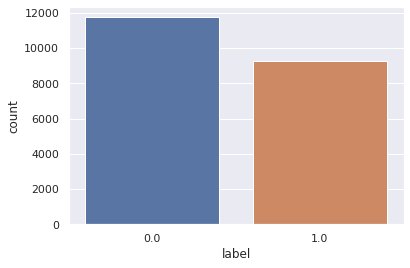

In [ ]:
#visualizing data distribution
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=told_br)

In [ ]:
texts=special_tokens(told_br.text)
texts=text_tokenize(texts)
told_br_inputs=adding_ids(texts)
told_br_inputs = pad_sequences(told_br_inputs, maxlen=400, dtype="long", truncating="post", padding="post")
told_br_inputs = torch.tensor(told_br_inputs)
told_br_masks=adding_masks(told_br_inputs)
told_br_masks = torch.tensor(told_br_masks)
told_br_dataset = TensorDataset(told_br_inputs, told_br_masks)
told_br_dataloader = DataLoader(told_br_dataset, shuffle=False, batch_size=32)
probs_told_br = bert_predict(bert_classifier, told_br_dataloader)
told_br_pred=[]
for i in probs_told_br:
    told_br_pred.append(i.argmax())
told_br_pred = pd.Index(told_br_pred)

[CLS] Meu nivel de amizade com isis é ela ter meu insta e eu ter o dela, e quando eu penso que não ela manda mensagem “ falano otario ta falando dnv no insta” [SEP]
['[CLS]', 'meu', 'nivel', 'de', 'ami', '##zade', 'com', 'isis', 'e', 'ela', 'ter', 'meu', 'inst', '##a', 'e', 'eu', 'ter', 'o', 'dela', ',', 'e', 'quando', 'eu', 'penso', 'que', 'nao', 'ela', 'manda', 'mens', '##agem', '[UNK]', 'fala', '##no', 'ota', '##rio', 'ta', 'fala', '##ndo', 'd', '##n', '##v', 'no', 'inst', '##a', '[UNK]', '[SEP]']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
actual = told_br['label']
predicted = told_br_pred
results = confusion_matrix(actual, predicted)

In [ ]:
from sklearn.metrics import classification_report
print ('Confusion Matrix :')
print(results) 
print ('Report : ')
print (classification_report(actual, predicted) )

Confusion Matrix :
[[6973 4772]
 [4909 4346]]
Report : 
              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59     11745
         1.0       0.48      0.47      0.47      9255

    accuracy                           0.54     21000
   macro avg       0.53      0.53      0.53     21000
weighted avg       0.54      0.54      0.54     21000



In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize  
words = word_tokenize(words)  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
dictionary={}

In [ ]:
for word in words:
  if word in dictionary:
    dictionary[word] += 1
  else:
    dictionary[word] = 1

In [ ]:
>>> dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

{',': 79387,
 'i': 40204,
 'the': 33499,
 ')': 26740,
 '(': 26719,
 'you': 25203,
 'a': 18583,
 "'": 16626,
 'it': 16311,
 'to': 14656,
 'and': 14631,
 'me': 12516,
 'my': 12422,
 "n't": 12400,
 'that': 11584,
 'in': 11231,
 ']': 11154,
 '[': 11152,
 '.': 10865,
 'on': 9978,
 "'s": 9885,
 "'m": 9058,
 "''": 8931,
 '``': 8761,
 'of': 8559,
 'do': 8444,
 'up': 7818,
 'yeah': 7762,
 'like': 7372,
 'â\x80\x94': 7259,
 'got': 6589,
 'with': 6485,
 ':': 6414,
 'we': 6235,
 '?': 6133,
 'your': 5743,
 'all': 5693,
 'for': 5522,
 '-': 5507,
 'know': 5172,
 'is': 4888,
 'no': 4563,
 'be': 4539,
 'this': 4430,
 'they': 4277,
 'but': 4159,
 'she': 4015,
 'get': 3992,
 'just': 3883,
 'what': 3620,
 'ai': 3527,
 'na': 3472,
 'out': 3393,
 'so': 3381,
 'when': 3327,
 'love': 3307,
 'chorus': 3300,
 '2018': 3193,
 '&': 3150,
 'verse': 3072,
 'was': 3072,
 'go': 2997,
 'if': 2802,
 'now': 2790,
 'her': 2747,
 'he': 2729,
 'oh': 2728,
 'at': 2672,
 'down': 2633,
 '!': 2619,
 'nigga': 2576,
 'bitch': 256